In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"
import random

import statsmodels.api as sm
import scipy.stats as stats

import yfinance as yf

In [2]:
# Define the ticker symbol for Apple
ticker = 'AAPL'

# Get the data of the stock
data = yf.download(ticker, start="2020-01-01", )
print(data.shape)

[*********************100%***********************]  1 of 1 completed

(1224, 6)


In [3]:
data.columns = data.columns.get_level_values(0)

In [4]:
data.head()

Price                      Adj Close      Close       High        Low  \
Date                                                                    
2020-01-02 00:00:00+00:00  72.796013  75.087502  75.150002  73.797501   
2020-01-03 00:00:00+00:00  72.088287  74.357498  75.144997  74.125000   
2020-01-06 00:00:00+00:00  72.662720  74.949997  74.989998  73.187500   
2020-01-07 00:00:00+00:00  72.320969  74.597504  75.224998  74.370003   
2020-01-08 00:00:00+00:00  73.484360  75.797501  76.110001  74.290001   

Price                           Open     Volume  
Date                                             
2020-01-02 00:00:00+00:00  74.059998  135480400  
2020-01-03 00:00:00+00:00  74.287498  146322800  
2020-01-06 00:00:00+00:00  73.447502  118387200  
2020-01-07 00:00:00+00:00  74.959999  108872000  
2020-01-08 00:00:00+00:00  74.290001  132079200

### PCA weights from a risk distribution R

In [5]:
def pcaWeights(cov, riskDist=None, riskTarget=1.):
    eVal, eVec = np.linalg.eig(cov)
    indices = eVal.argsort()[::-1]
    eVal, eVec = eVal[indices], eVec[:, indices]
    if riskDist is None:
        riskDist = np.zeros(cov.shape[0])
        riskDist[-1] = 1
    loads = riskTarget * (riskDist/eVal)**.5
    wghts = np.dot(eVec, loads.reshape(-1, 1))
    return wghts

In [6]:
matrixSize = 3 
np.random.seed(0)
A = np.random.rand(matrixSize, matrixSize)
B = np.dot(A, A.transpose())
pcaWeights(B)

array([[ 4.91041938],
       [-3.132718  ],
       [-1.73855105]])

#### The symmetric CUSUM Filter

In [7]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i]), min(0, sNeg + diff.loc[i])
        if sPos > h:
            sPos = 0
            tEvents.append(i)
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
    return tEvents

In [8]:
data

Price                       Adj Close       Close        High         Low  \
Date                                                                        
2020-01-02 00:00:00+00:00   72.796013   75.087502   75.150002   73.797501   
2020-01-03 00:00:00+00:00   72.088287   74.357498   75.144997   74.125000   
2020-01-06 00:00:00+00:00   72.662720   74.949997   74.989998   73.187500   
2020-01-07 00:00:00+00:00   72.320969   74.597504   75.224998   74.370003   
2020-01-08 00:00:00+00:00   73.484360   75.797501   76.110001   74.290001   
...                               ...         ...         ...         ...   
2024-11-05 00:00:00+00:00  223.204422  223.449997  223.949997  221.139999   
2024-11-06 00:00:00+00:00  222.475235  222.720001  226.070007  221.190002   
2024-11-07 00:00:00+00:00  227.229996  227.479996  227.880005  224.570007   
2024-11-08 00:00:00+00:00  226.960007  226.960007  228.660004  226.410004   
2024-11-11 00:00:00+00:00  224.229996  224.229996  225.699997  221.500000   

Price                            Open     Volume  
Date                                              
2020-01-02 00:00:00+00:00   74.059998  135480400  
2020-01-03 00:00:00+00:00   74.287498  146322800  
2020-01-06 00:00:00+00:00   73.447502  118387200  
2020-01-07 00:00:00+00:00   74.959999  108872000  
2020-01-08 00:00:00+00:00   74.290001  132079200  
...                               ...        ...  
2024-11-05 00:00:00+00:00  221.800003   28111300  
2024-11-06 00:00:00+00:00  222.610001   54561100  
2024-11-07 00:00:00+00:00  224.630005   42137700  
2024-11-08 00:00:00+00:00  227.169998   38308700  
2024-11-11 00:00:00+00:00  225.054993   41415717  

[1224 rows x 6 columns]

In [9]:
prices = data['Close']
events = getTEvents(prices, 5)

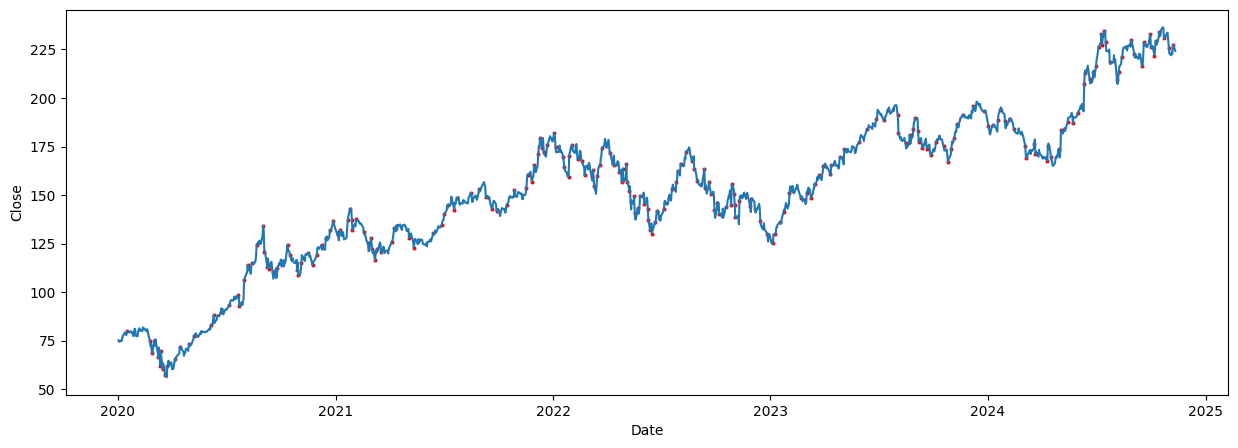

In [10]:
plt.figure(figsize=(15,5))
sns.lineplot(data['Close'])
sns.scatterplot(x=pd.Series(events),y=data.loc[events,'Close'].values.reshape(-1), s=10, color="red")
plt.show()

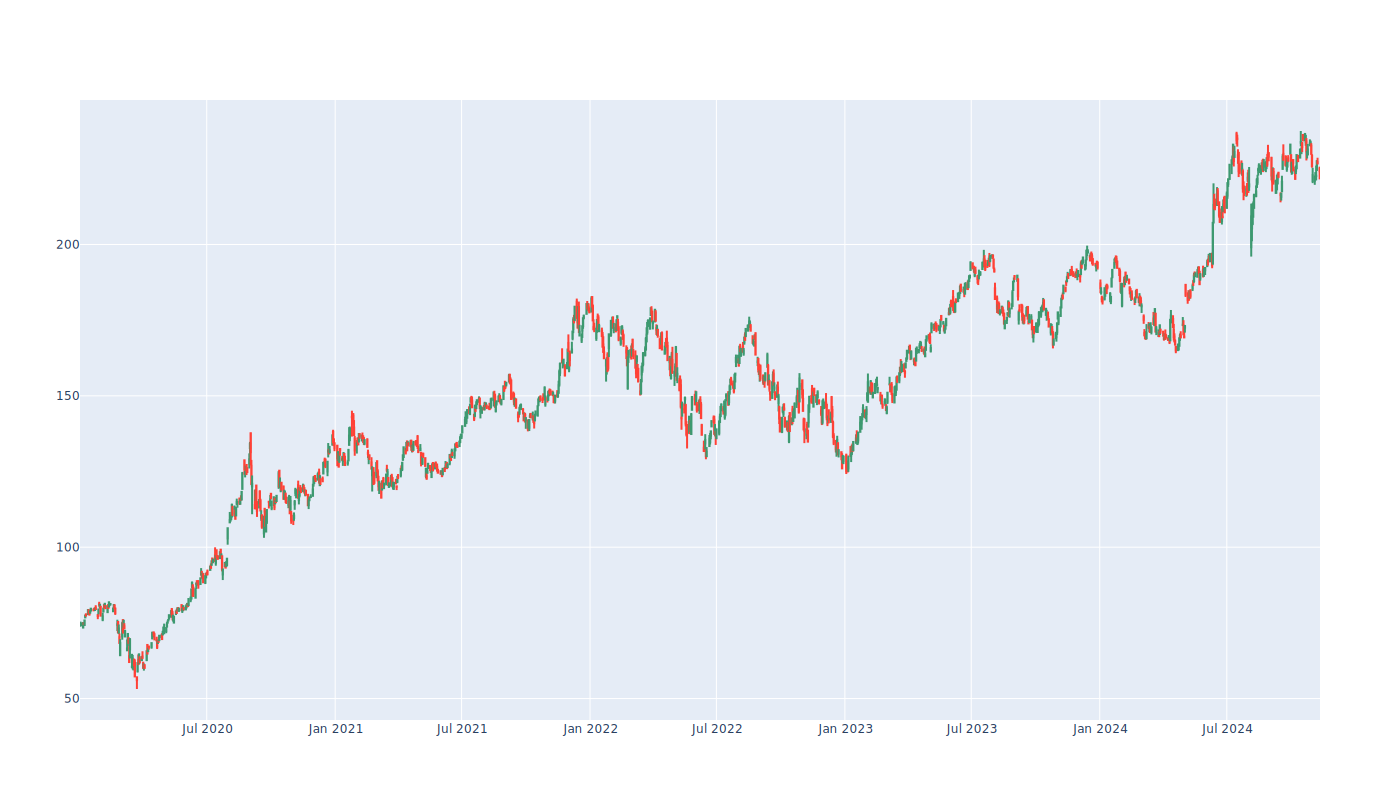

In [11]:
import plotly.graph_objects as go
from datetime import datetime

df = data.reset_index().copy()
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.update_layout(
    width=1400,  # Width in pixels
    height=800,  # Height in pixels
    xaxis_rangeslider_visible=False
)
fig.show()

In [13]:
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
import pandas as pd


app = Dash(__name__)

app.layout = html.Div([
    html.H4('Apple stock candlestick chart'),
    dcc.Checklist(
        id='toggle-rangeslider',
        options=[{'label': 'Include Rangeslider', 
                  'value': 'slider'}],
        value=['slider']
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("toggle-rangeslider", "value"))
def display_candlestick(value):
    df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv') # replace with your own data source
    fig = go.Figure(go.Candlestick(
        x=df['Date'],
        open=df['AAPL.Open'],
        high=df['AAPL.High'],
        low=df['AAPL.Low'],
        close=df['AAPL.Close']
    ))

    fig.update_layout(
        xaxis_rangeslider_visible='slider' in value
    )

    return fig


app.run_server(debug=True)

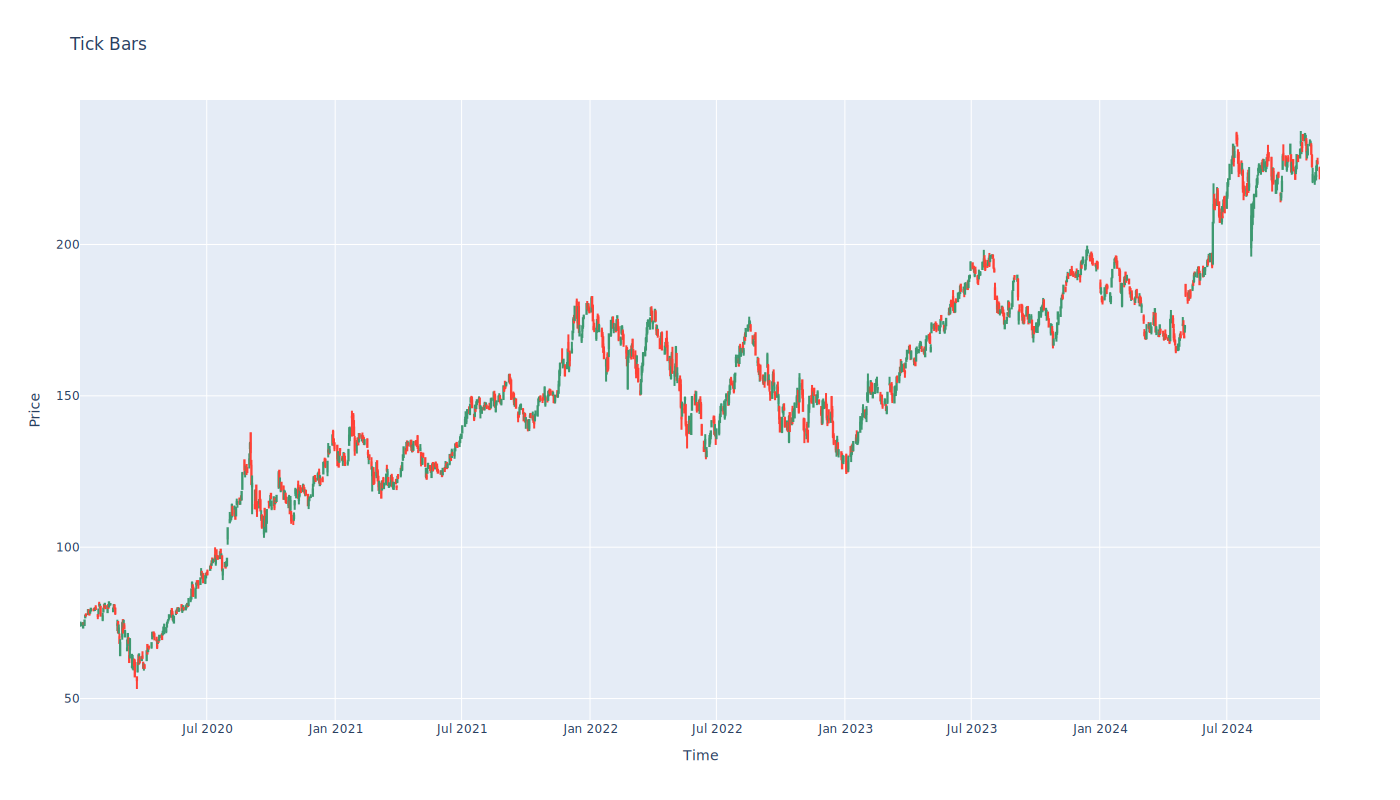

In [14]:
# 10 trades per bar
fig = go.Figure(
    data=[go.Candlestick(x=df['Date'].values,  open=df['Open'].values,
                                     high=df['High'].values, low=df['Low'].values, close=df['Close'].values)]
).update_layout(xaxis_title="Time",
                 yaxis_title="Price", 
                 title="Tick Bars", 
                 xaxis_rangeslider_visible=False,
                 width=1400,  # Width in pixels
                height=800,  # Height in pixels
                )
fig.show()

## Exercise

In [15]:
## get the data
es_data = yf.download("ES=F", start='2023-01-01', end='2024-11-10', interval="1h") 
print(es_data.shape)

[*********************100%***********************]  1 of 1 completed

(10663, 6)


In [16]:
es_data.head()

Price                     Adj Close    Close     High      Low     Open Volume
Ticker                         ES=F     ES=F     ES=F     ES=F     ES=F   ES=F
Datetime                                                                      
2023-01-03 05:00:00+00:00   3871.50  3871.50  3873.75  3864.00  3864.00   8894
2023-01-03 06:00:00+00:00   3870.50  3870.50  3874.25  3866.25  3871.50   7627
2023-01-03 07:00:00+00:00   3881.75  3881.75  3882.00  3865.75  3870.25  16333
2023-01-03 08:00:00+00:00   3895.25  3895.25  3897.00  3877.50  3881.50  38641
2023-01-03 09:00:00+00:00   3906.00  3906.00  3906.25  3894.50  3895.25  36179

In [17]:
es_data.columns = es_data.columns.get_level_values(0)

In [18]:
es_data.head()

Price                      Adj Close    Close     High      Low     Open  \
Datetime                                                                   
2023-01-03 05:00:00+00:00    3871.50  3871.50  3873.75  3864.00  3864.00   
2023-01-03 06:00:00+00:00    3870.50  3870.50  3874.25  3866.25  3871.50   
2023-01-03 07:00:00+00:00    3881.75  3881.75  3882.00  3865.75  3870.25   
2023-01-03 08:00:00+00:00    3895.25  3895.25  3897.00  3877.50  3881.50   
2023-01-03 09:00:00+00:00    3906.00  3906.00  3906.25  3894.50  3895.25   

Price                      Volume  
Datetime                           
2023-01-03 05:00:00+00:00    8894  
2023-01-03 06:00:00+00:00    7627  
2023-01-03 07:00:00+00:00   16333  
2023-01-03 08:00:00+00:00   38641  
2023-01-03 09:00:00+00:00   36179

In [19]:
def advanced_bars(series, h, bar_type = 'Volume'):
    index_name = es_data.index.name
    df = pd.DataFrame()
    temp_data = series.reset_index()
    current_vol = 0
    for i in range(len(temp_data)):
        if current_vol == 0:
                date, cum_high,cum_low,cum_open,cum_close,cum_adj_close = temp_data.iloc[i][index_name],temp_data.iloc[i]['High'],temp_data.iloc[i]['Low'],temp_data.iloc[i]['Open'],temp_data.iloc[i]['Close'],temp_data.iloc[i]['Adj Close']
        cum_high, cum_low = max(cum_high, temp_data.iloc[i]['High']), min(cum_low, temp_data.iloc[i]['Low'])
        if bar_type == 'Volume':
            current_vol += temp_data.iloc[i]['Volume']
        elif bar_type == 'Dollar':
            current_vol += temp_data.iloc[i]['Volume'] * temp_data.iloc[i]['Close']
        elif bar_type == 'Tick':
            current_vol += 1
        else:
            raise ValueError("bar_type Wrong! Please enter correct bar_type: Volume, Dollar or Tick")

        if (current_vol >= h):
            cum_close = temp_data.iloc[i][ 'Close']
            cum_adj_close = temp_data.iloc[i]['Adj Close']
            temp = pd.DataFrame([[date, cum_adj_close, cum_close, cum_high, cum_low, cum_open, current_vol]], columns = [index_name,'Adj Close','Close','High','Low','Open','Cum '+bar_type])
            current_vol = 0
            df = pd.concat([df, temp], axis=0)
    df.set_index(index_name, inplace=True)
    return df

In [20]:
tick_bars = advanced_bars(es_data, h=2, bar_type='Tick')
tick_bars.shape

(5331, 6)

In [21]:
volume_bars = advanced_bars(es_data, h=20000, bar_type='Volume')
volume_bars.shape

(6358, 6)

In [22]:
dollar_bars = advanced_bars(es_data, h=20000*5000, bar_type='Dollar')
dollar_bars.shape

(6274, 6)

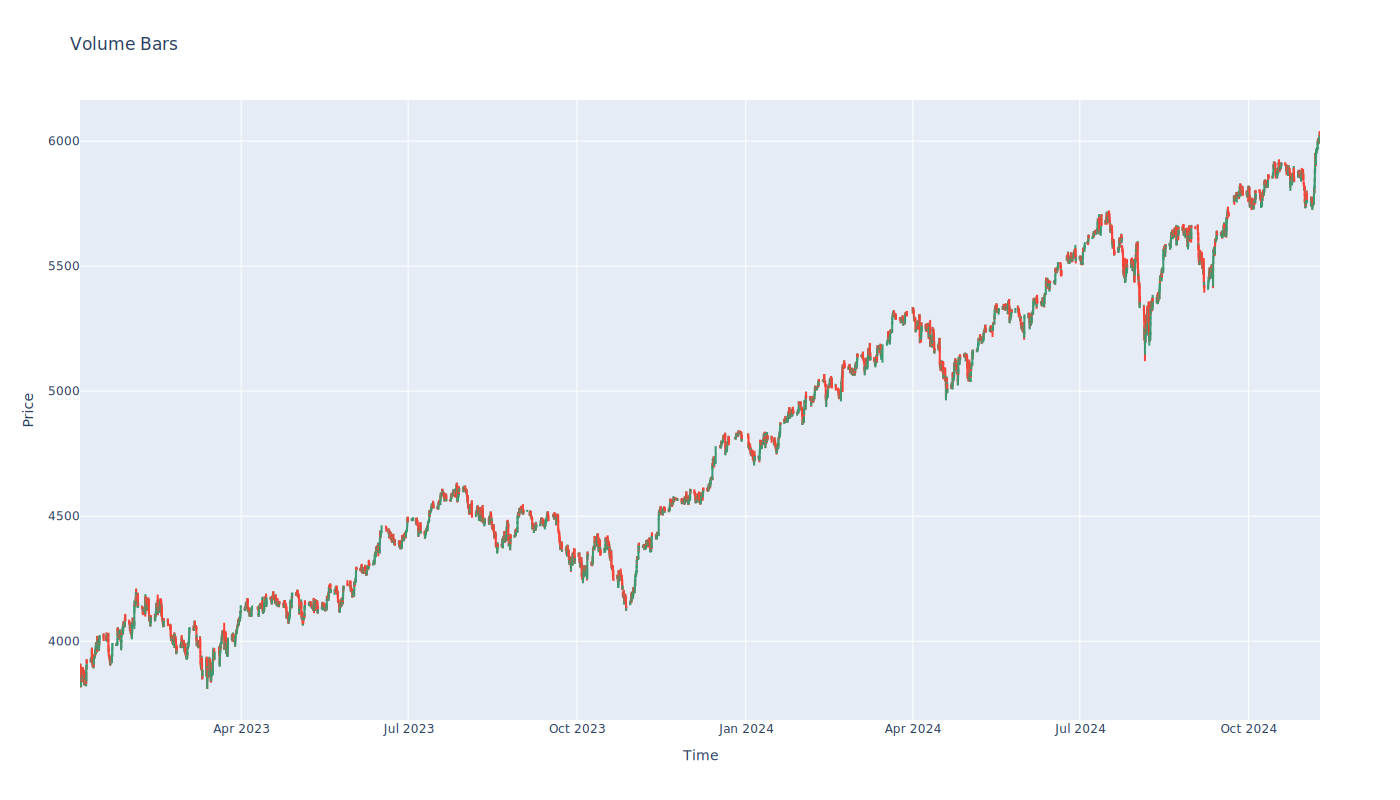

In [23]:
# 10 trades per bar
df = volume_bars.reset_index()
fig = go.Figure(
    data=[go.Candlestick(x=df['Datetime'],  
                        open=df['Open'],
                        high=df['High'], 
                        low=df['Low'], 
                        close=df['Close'])]
).update_layout(xaxis_title="Time",
                 yaxis_title="Price", 
                 title="Volume Bars", 
                 xaxis_rangeslider_visible=False,
                 width=1400,  # Width in pixels
                height=800,  # Height in pixels
                )
fig.show()

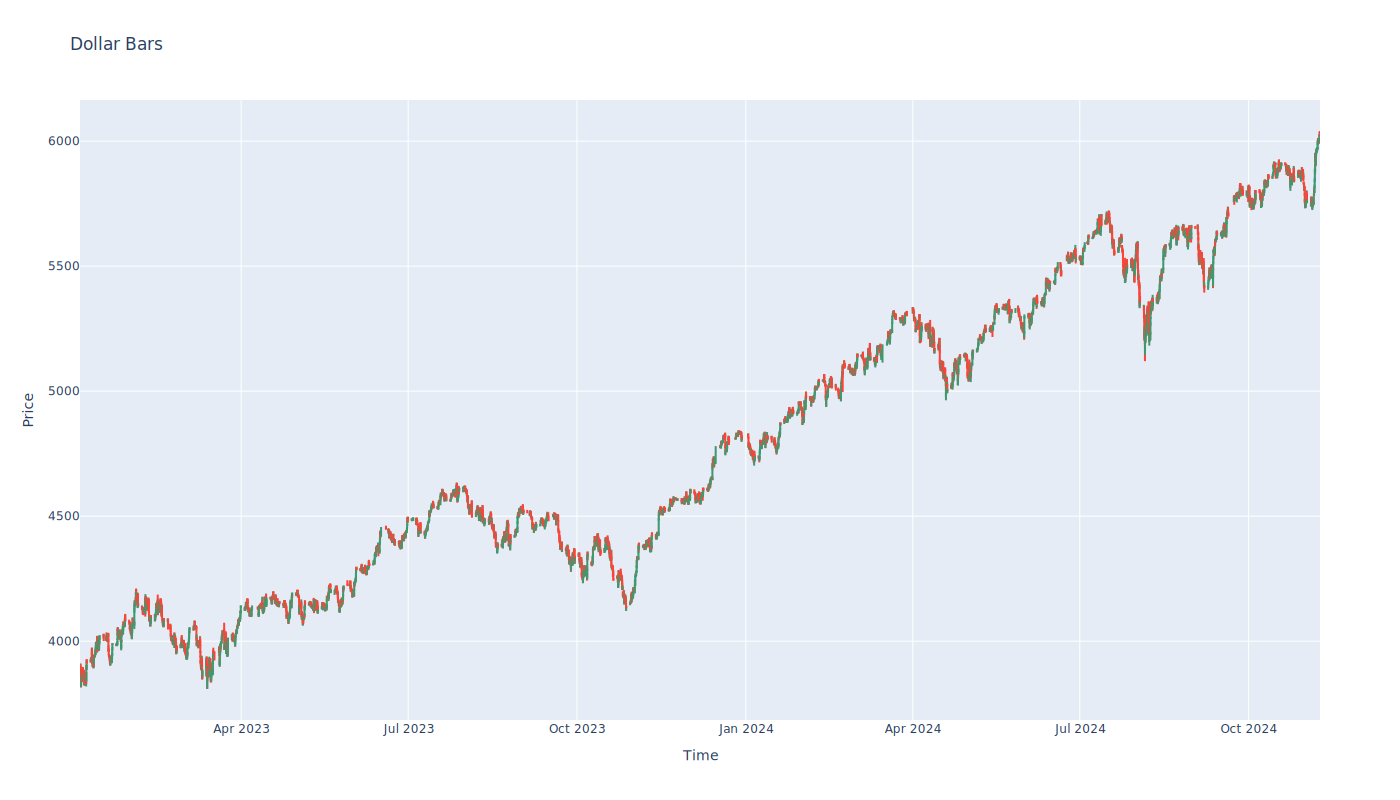

In [24]:
# 10 trades per bar
df = dollar_bars.reset_index()
fig = go.Figure(
    data=[go.Candlestick(x=df['Datetime'],  
                        open=df['Open'],
                        high=df['High'], 
                        low=df['Low'], 
                        close=df['Close'])]
).update_layout(xaxis_title="Time",
                 yaxis_title="Price", 
                 title="Dollar Bars", 
                 xaxis_rangeslider_visible=False,
                 width=1400,  # Width in pixels
                height=800,  # Height in pixels
                )
fig.show()

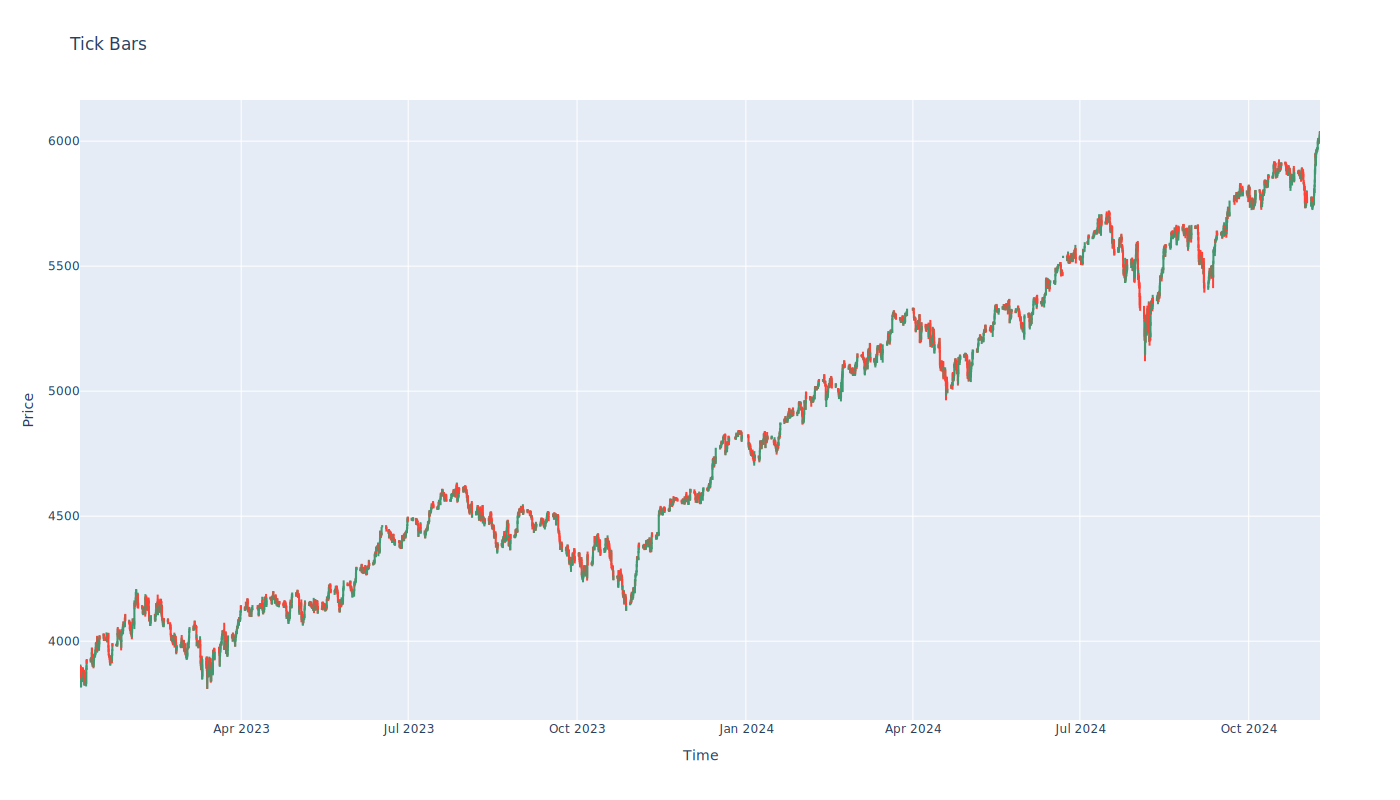

In [25]:
# 10 trades per bar
df = tick_bars.reset_index()
fig = go.Figure(
    data=[go.Candlestick(x=df['Datetime'],  
                        open=df['Open'],
                        high=df['High'], 
                        low=df['Low'], 
                        close=df['Close'])]
).update_layout(xaxis_title="Time",
                 yaxis_title="Price", 
                 title="Tick Bars", 
                 xaxis_rangeslider_visible=False,
                 width=1400,  # Width in pixels
                height=800,  # Height in pixels
                )
fig.show()

In [26]:
tick_bars

Adj Close    Close     High      Low     Open  \
Datetime                                                                   
2023-01-03 05:00:00+00:00    3870.50  3870.50  3874.25  3864.00  3864.00   
2023-01-03 07:00:00+00:00    3895.25  3895.25  3897.00  3865.75  3870.25   
2023-01-03 09:00:00+00:00    3897.25  3897.25  3906.75  3893.50  3895.25   
2023-01-03 11:00:00+00:00    3880.00  3880.00  3898.50  3870.25  3897.25   
2023-01-03 13:00:00+00:00    3854.00  3854.00  3901.50  3853.25  3879.75   
...                              ...      ...      ...      ...      ...   
2024-11-08 11:00:00+00:00    6002.25  6002.25  6002.75  5990.25  5994.25   
2024-11-08 13:00:00+00:00    6015.00  6015.00  6015.50  5997.50  6002.00   
2024-11-08 15:00:00+00:00    6022.75  6022.75  6025.50  6008.50  6014.50   
2024-11-08 17:00:00+00:00    6034.00  6034.00  6036.00  6017.75  6023.00   
2024-11-08 19:00:00+00:00    6027.25  6027.25  6040.50  6020.00  6034.00   

                           Cum Tick  
Datetime                             
2023-01-03 05:00:00+00:00         2  
2023-01-03 07:00:00+00:00         2  
2023-01-03 09:00:00+00:00         2  
2023-01-03 11:00:00+00:00         2  
2023-01-03 13:00:00+00:00         2  
...                             ...  
2024-11-08 11:00:00+00:00         2  
2024-11-08 13:00:00+00:00         2  
2024-11-08 15:00:00+00:00         2  
2024-11-08 17:00:00+00:00         2  
2024-11-08 19:00:00+00:00         2  

[5331 rows x 6 columns]

In [27]:
tick_counts = tick_bars.resample('W-MON')['Close'].count()
dollar_counts = dollar_bars.resample('W-MON')['Close'].count()
volume_counts = volume_bars.resample('W-MON')['Close'].count()

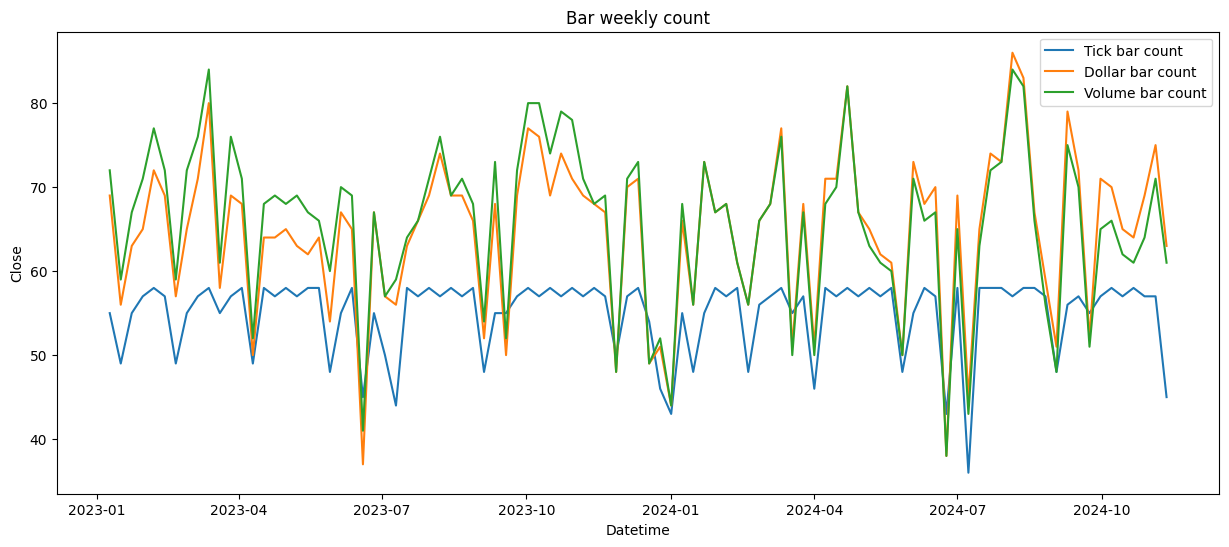

In [28]:
plt.figure(figsize=(15, 6))
sns.lineplot(tick_counts, label='Tick bar count')
sns.lineplot(dollar_counts, label = 'Dollar bar count')
sns.lineplot(volume_counts, label = 'Volume bar count')
plt.title("Bar weekly count")
plt.show()

In [29]:
count_df = pd.DataFrame(columns = ['count_mean', 'count_std'], index=['tick', 'volume', 'dollar'])
count_df.loc['tick'] = [tick_counts.mean(), tick_counts.std()]
count_df.loc['volume'] = [volume_counts.mean(), volume_counts.std()]
count_df.loc['dollar'] = [dollar_counts.mean(), dollar_counts.std()]
count_df

count_mean count_std
tick    54.958763  4.564166
volume  65.546392  9.721133
dollar  64.680412  9.403619

In [30]:
def returns(s):
    arr = np.diff(np.log(s))
    return pd.Series(arr, index=s.index[1:])

In [31]:
def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds)) for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct).rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'}).T)
    return df

In [32]:
tick_returns = returns(tick_bars['Close'])
volume_returns = returns(volume_bars['Close'])
dollar_returns = returns(dollar_bars['Close'])
df_returns = returns(es_data['Close'])
bar_types = ['tick','volume','dollar','df']
bar_returns = [tick_returns, volume_returns, dollar_returns, df_returns]
pd.DataFrame([tick_returns.autocorr(), volume_returns.autocorr(), dollar_returns.autocorr(), df_returns.autocorr()], columns=['returns_corr'], index=['tick', 'volume', 'dollar', 'df'])

returns_corr
tick       -0.004728
volume      0.018689
dollar      0.021499
df          0.009491

In [33]:
def partition_monthly(s):
    return s.resample("1ME").var()

In [34]:
tick_monthly = partition_monthly(tick_returns)
volume_monthly = partition_monthly(volume_returns)
dollar_monthly = partition_monthly(dollar_returns)
df_monthly = partition_monthly(df_returns)
monthly_vars = [tick_monthly, volume_monthly, dollar_monthly, df_monthly]
get_test_stats(bar_types, monthly_vars, np.var).sort_values(by='var_stat')

sample_size      var_stat
df             23.0  2.034432e-12
volume         23.0  4.661078e-12
dollar         23.0  5.393506e-12
tick           23.0  8.490672e-12

In [35]:
print(tick_monthly.var())
print(volume_monthly.var())
print(dollar_monthly.var())

8.876611991157265e-12
4.872945192072907e-12
5.638665593871773e-12


In [36]:
def jb(x, test=True):
    np.random.seed(12)
    if test:
        return stats.jarque_bera(x)[0]
    return stats.jarque_bera(x)[1]

get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')

sample_size       jb_stat
dollar       6273.0   6569.393797
volume       6357.0   6593.125405
tick         5330.0  14179.377573
df          10662.0  45740.783640

In [38]:
def shapiro(x,test=True): 
    np.random.seed(12345678)
    if test: return stats.shapiro(x)[0]
    return stats.shapiro(x)[1]

get_test_stats(bar_types,bar_returns,shapiro).sort_values('shapiro_stat')[::-1]

/home/zhi/miniconda3/envs/finance/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5330.

/home/zhi/miniconda3/envs/finance/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6357.

/home/zhi/miniconda3/envs/finance/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6273.

/home/zhi/miniconda3/envs/finance/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10662.



sample_size  shapiro_stat
volume       6357.0      0.943328
dollar       6273.0      0.942556
tick         5330.0      0.884023
df          10662.0      0.871053

#### Imbance bars

In [39]:
ib_data = es_data.copy()

In [40]:
from numba import jit
from tqdm import tqdm

@jit(nopython=True)
def numba_isclose(a,b,rel_tol=1e-09,abs_tol=0.0):
    return np.fabs(a-b) <= np.fmax(rel_tol*np.fmax(np.fabs(a), np.fabs(b)), abs_tol)

@jit(nopython=True)
def bt(p0, p1, bs):
    # if p0 and p1 are close enough, return the last element of bs
    # else return the sign of p1-p0
    #if math.isclose((p1 - p0), 0.0, abs_tol=0.001):
    if numba_isclose((p1-p0),0.0,abs_tol=0.001):
        b = bs[-1]
        return b
    else:
        b = np.abs(p1-p0)/(p1-p0)
        return b

@jit(nopython=True)
def get_imbalance(t):
    bs = np.zeros_like(t)
    for i in np.arange(1, bs.shape[0]):
        t_bt = bt(t[i-1], t[i], bs[:i-1])
        bs[i-1] = t_bt
    return bs[:-1] # remove last value

In [41]:
df = es_data.copy()
df['price'] = df['Close']
df['v'] = df['Volume']
df['dv'] = df['v'] * df['price']
df.shape

(10663, 9)

In [42]:
# signed dollar values
tidx = get_imbalance(df.price.values)*df.dv.iloc[1:]
tidx

Datetime
2023-01-03 06:00:00+00:00   -2.952030e+07
2023-01-03 07:00:00+00:00    6.340062e+07
2023-01-03 08:00:00+00:00    1.505164e+08
2023-01-03 09:00:00+00:00    1.413152e+08
2023-01-03 10:00:00+00:00   -8.152657e+07
                                 ...     
2024-11-08 17:00:00+00:00    5.372812e+08
2024-11-08 18:00:00+00:00    4.648292e+08
2024-11-08 19:00:00+00:00   -5.001538e+08
2024-11-08 20:00:00+00:00   -1.378438e+09
2024-11-08 21:00:00+00:00   -3.058974e+08
Name: dv, Length: 10662, dtype: float64

In [43]:
wndo = tidx.shape[0]//1000
print(f'window size: {wndo:,.2f}')

## Expected value of bs approximated by ewm
## Espected dollar values
E_bs = tidx.ewm(wndo).mean() # expected `bs`

## what is E_T??? 
## in this implementation E_T is ewm of index values
E_T = pd.Series(range(tidx.shape[0]), index=tidx.index).ewm(wndo).mean()

df0 =(pd.DataFrame().assign(bs=tidx)
      .assign(E_T=E_T).assign(E_bs=E_bs)
      .assign(absMul=lambda df: df.E_T*np.abs(df.E_bs))
      .assign(absTheta=tidx.cumsum().abs()))
df0

window size: 10.00


bs           E_T          E_bs  \
Datetime                                                              
2023-01-03 06:00:00+00:00 -2.952030e+07      0.000000 -2.952030e+07   
2023-01-03 07:00:00+00:00  6.340062e+07      0.523810  1.915256e+07   
2023-01-03 08:00:00+00:00  1.505164e+08      1.063444  6.717377e+07   
2023-01-03 09:00:00+00:00  1.413152e+08      1.618832  8.843690e+07   
2023-01-03 10:00:00+00:00 -8.152657e+07      2.189874  4.767696e+07   
...                                 ...           ...           ...   
2024-11-08 17:00:00+00:00  5.372812e+08  10647.000000  2.411319e+08   
2024-11-08 18:00:00+00:00  4.648292e+08  10648.000000  2.614680e+08   
2024-11-08 19:00:00+00:00 -5.001538e+08  10649.000000  1.922296e+08   
2024-11-08 20:00:00+00:00 -1.378438e+09  10650.000000  4.944166e+07   
2024-11-08 21:00:00+00:00 -3.058974e+08  10651.000000  1.713810e+07   

                                 absMul      absTheta  
Datetime                                               
2023-01-03 06:00:00+00:00  0.000000e+00  2.952030e+07  
2023-01-03 07:00:00+00:00  1.003229e+07  3.388032e+07  
2023-01-03 08:00:00+00:00  7.143555e+07  1.843967e+08  
2023-01-03 09:00:00+00:00  1.431645e+08  3.257118e+08  
2023-01-03 10:00:00+00:00  1.044065e+08  2.441853e+08  
...                                 ...           ...  
2024-11-08 17:00:00+00:00  2.567331e+12  9.427365e+10  
2024-11-08 18:00:00+00:00  2.784111e+12  9.473848e+10  
2024-11-08 19:00:00+00:00  2.047053e+12  9.423833e+10  
2024-11-08 20:00:00+00:00  5.265536e+11  9.285989e+10  
2024-11-08 21:00:00+00:00  1.825379e+11  9.255399e+10  

[10662 rows x 5 columns]

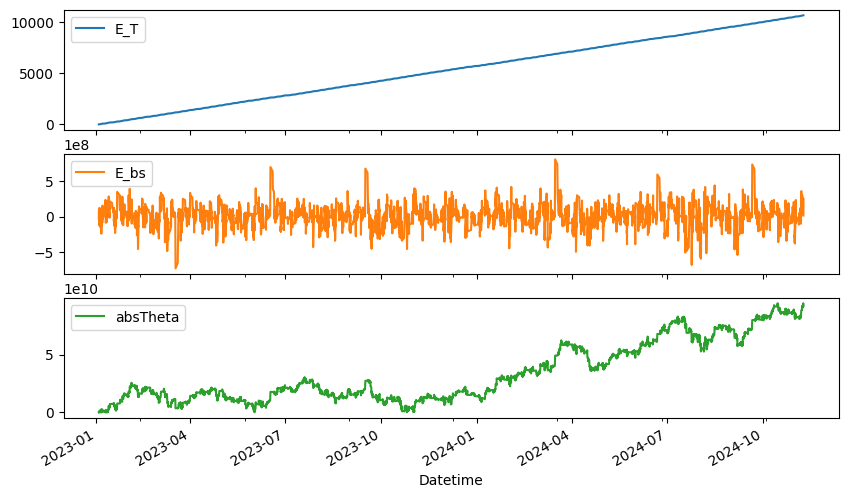

In [44]:
df0[['E_T','E_bs', 'absTheta']].plot(subplots=True, figsize=(10,6))
plt.show()

In [45]:
display(df0.describe()/1000)

bs        E_T           E_bs        absMul      absTheta
count  1.066200e+01  10.662000      10.662000  1.066200e+01  1.066200e+01
mean   8.680735e+03   5.320516    8686.101641  4.759336e+08  3.402895e+07
std    5.507704e+05   3.077970  123098.237997  6.430059e+08  2.616362e+07
min   -8.153837e+06   0.000000 -732288.300595  0.000000e+00  1.938869e+04
25%   -6.627690e+04   2.655250  -46510.126945  7.421040e+07  1.300723e+07
50%    1.011756e+04   5.320500   10700.195579  2.394007e+08  2.116184e+07
75%    8.506274e+04   7.985750   70079.893789  6.055491e+08  5.678531e+07
max    8.983495e+06  10.651000  814146.615606  7.297943e+09  9.473848e+07

<Axes: >

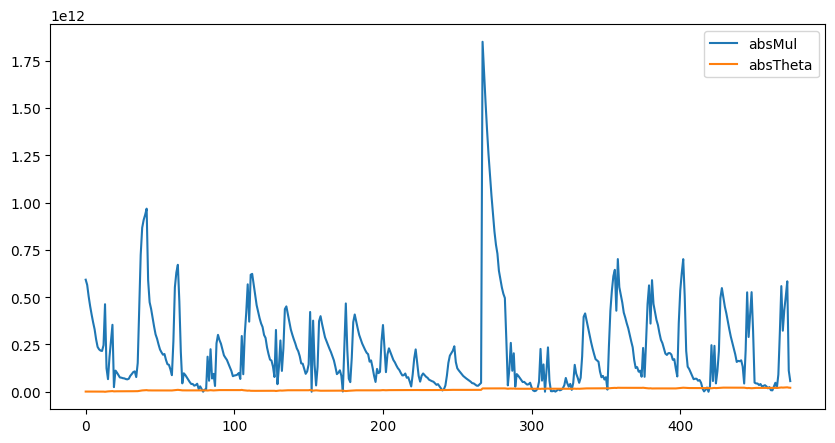

In [46]:
(df0.loc['2023-06',['absMul','absTheta']].reset_index(drop=True).plot(figsize=(10,5)))

In [47]:
def calculate_dollar_imbalance_bars(df, initial_threshold, ewma_alpha=0.95, bar_type = 'Dollar'):
    """
    Calculate dollar imbalance bars with an EWMA-adjusted threshold as per de Prado's method.
    
    Parameters:
    df (pd.DataFrame): A DataFrame with columns ['date', 'open', 'close', 'high', 'low', 'volume'].
    initial_threshold (float): Initial imbalance threshold for triggering a bar.
    ewma_alpha (float): Smoothing factor for EWMA (e.g., 0.95 gives strong weighting to recent observations).
    
    Returns:
    pd.DataFrame: A DataFrame containing the dollar imbalance bars.
    """
    name = df.index.name
    df = df.reset_index()
    imbalance_bars = []  # Store completed imbalance bars
    cumulative_signed_flow = 0  # Tracks cumulative signed imbalance flow
    ewma_threshold = initial_threshold  # Set initial threshold
    Date, Open, High, Low, Volume =df[name].iloc[0], df['Open'].iloc[0], df['High'].iloc[0], df['Low'].iloc[0], df['Volume'].iloc[0]
    i_prev = 0
    T_array = []
    imbalance_array = []
    
    for i in range(1, len(df)):
        price_change = df['Close'].iloc[i] - df['Close'].iloc[i - 1]
        tick_direction = np.sign(price_change)  # Determine tick direction
        if bar_type == 'Dollar':
            signed_flow = tick_direction * df['Volume'].iloc[i] * df['Close'].iloc[i]  # Calculate signed flow
        elif bar_type == 'Volume':
            signed_flow = tick_direction * df['Volume'].iloc[i]
        elif bar_type == 'Tick':
            signed_flow = tick_direction * 1
        else:
            raise ValueError("Wrong bar_type, please select the correct type: Dollar, Volume, Tick")
        
        cumulative_signed_flow += signed_flow  # Accumulate signed flow
        imbalance_array.append(signed_flow)
        
        Volume += df['Volume'].iloc[i]
        High = max(High, df['High'].iloc[i])
        Low = min(Low, df['Low'].iloc[i])

        # Check if we should create a new bar
        if abs(cumulative_signed_flow) >= ewma_threshold:
            # Add the current bar's details to the bars list
            bar = {
                name: Date,
                'Open': Open,
                'Close': df['Close'].iloc[i],
                'High': High,
                'Low': Low,
                'Volume': Volume,
                'Adj Close': df['Adj Close'].iloc[i],
                'Cumulative_signed_flow': cumulative_signed_flow,
                'Threshold': ewma_threshold
            }
            if (i < len(df)-1):
                Open = df['Open'].iloc[i + 1]
                High = df['High'].iloc[i + 1]
                Low = df['Low'].iloc[i + 1]
                Date = df[name].iloc[i + 1]
            i_prev = i
            T_array.append(i - i_prev + 1)
            
            imbalance_bars.append(bar)
            
            # Update cumulative imbalance and EWMA threshold
            E_imbalance = pd.Series(imbalance_array).ewm(alpha=ewma_alpha).mean().values[-1]
            E_T = pd.Series(T_array).ewm(alpha=ewma_alpha).mean().values[-1]
            ewma_threshold = E_T * E_imbalance
            # Reset cumulative signed flow for the next bar
            cumulative_signed_flow = 0
            Volume = 0

    # Return result as a DataFrame
    imbalance_bars_df = pd.DataFrame(imbalance_bars)
    return imbalance_bars_df

# Example usage:
# Assuming df is a DataFrame with the necessary columns.
# initial_threshold = 1e6  # Set the initial threshold value
# ewma_alpha = 0.95  # Smoothing factor for EWMA threshold
# imbalance_bars_df = calculate_dollar_imbalance_bars(df, initial_threshold, ewma_alpha)


In [48]:
df.shape

(10663, 9)

In [49]:
dollar_imb_bars = calculate_dollar_imbalance_bars(df, initial_threshold=10000)
dollar_imb_bars

Datetime     Open    Close     High      Low  Volume  \
0    2023-01-03 05:00:00+00:00  3864.00  3870.50  3874.25  3864.00   16521   
1    2023-01-03 07:00:00+00:00  3870.25  3881.75  3882.00  3865.75   16333   
2    2023-01-03 08:00:00+00:00  3881.50  3895.25  3897.00  3877.50   38641   
3    2023-01-03 09:00:00+00:00  3895.25  3884.00  3906.75  3870.25  207805   
4    2023-01-03 14:00:00+00:00  3884.25  3854.00  3901.50  3853.25  255200   
...                        ...      ...      ...      ...      ...     ...   
3001 2024-11-07 23:00:00+00:00  6007.75  6015.00  6015.50  5990.25  278252   
3002 2024-11-08 15:00:00+00:00  6014.50  6021.25  6023.00  6008.50  156969   
3003 2024-11-08 16:00:00+00:00  6021.00  6024.75  6027.00  6016.75  180166   
3004 2024-11-08 18:00:00+00:00  6024.75  6027.25  6040.50  6020.00  388639   
3005 2024-11-08 21:00:00+00:00  6027.00  6023.50  6029.00  6023.25   50784   

      Adj Close  Cumulative_signed_flow     Threshold  
0       3870.50           -2.952030e+07  1.000000e+04  
1       3881.75            6.340062e+07 -2.952030e+07  
2       3895.25            1.505164e+08  5.897582e+07  
3       3884.00            3.755918e+08  1.459502e+08  
4       3854.00           -9.835408e+08  2.955654e+08  
...         ...                     ...           ...  
3001    6015.00            6.818502e+08  3.360001e+08  
3002    6021.25            9.451496e+08  7.314873e+08  
3003    6024.75            1.085273e+09  9.344665e+08  
3004    6027.25           -1.413763e+09  5.387829e+08  
3005    6023.50           -3.058974e+08 -1.332102e+09  

[3006 rows x 9 columns]

In [50]:
volume_imb_bars = calculate_dollar_imbalance_bars(df, initial_threshold=10000, bar_type='Volume')
volume_imb_bars

Datetime     Open    Close     High      Low  Volume  \
0    2023-01-03 05:00:00+00:00  3864.00  3895.25  3897.00  3864.00   71495   
1    2023-01-03 09:00:00+00:00  3895.25  3884.00  3906.75  3870.25  207805   
2    2023-01-03 14:00:00+00:00  3884.25  3854.00  3901.50  3853.25  255200   
3    2023-01-03 15:00:00+00:00  3854.25  3857.25  3862.50  3837.25  219527   
4    2023-01-03 16:00:00+00:00  3857.25  3827.25  3860.00  3823.00  197673   
...                        ...      ...      ...      ...      ...     ...   
2979 2024-11-07 23:00:00+00:00  6007.75  6015.00  6015.50  5990.25  278252   
2980 2024-11-08 15:00:00+00:00  6014.50  6021.25  6023.00  6008.50  156969   
2981 2024-11-08 16:00:00+00:00  6021.00  6024.75  6027.00  6016.75  180166   
2982 2024-11-08 18:00:00+00:00  6024.75  6027.25  6040.50  6020.00  388639   
2983 2024-11-08 21:00:00+00:00  6027.00  6023.50  6029.00  6023.25   50784   

      Adj Close  Cumulative_signed_flow      Threshold  
0       3895.25                 47347.0   10000.000000  
1       3884.00                 96545.0   37471.337292  
2       3854.00               -255200.0   76099.888768  
3       3857.25                219527.0 -238635.005562  
4       3827.25               -197673.0  196618.899722  
...         ...                     ...            ...  
2979    6015.00                113283.0   55931.797551  
2980    6021.25                156969.0  121607.407652  
2981    6024.75                180166.0  155200.920383  
2982    6027.25               -234569.0   89429.934801  
2983    6023.50                -50784.0 -221009.705633  

[2984 rows x 9 columns]

In [51]:
tick_imb_bars = calculate_dollar_imbalance_bars(df, initial_threshold=4, bar_type='Tick')
tick_imb_bars

Datetime     Open    Close     High      Low   Volume  \
0     2023-01-03 05:00:00+00:00  3864.00  3853.00  3906.75  3814.50  1657275   
1     2023-01-04 05:00:00+00:00  3853.00  3852.00  3854.00  3849.00     6162   
2     2023-01-04 06:00:00+00:00  3852.00  3853.25  3854.25  3847.25     5698   
3     2023-01-04 07:00:00+00:00  3853.25  3857.25  3858.00  3852.00    13676   
4     2023-01-04 08:00:00+00:00  3857.25  3861.00  3866.25  3856.50    35070   
...                         ...      ...      ...      ...      ...      ...   
10508 2024-11-08 17:00:00+00:00  6023.00  6024.75  6027.00  6017.75    89179   
10509 2024-11-08 18:00:00+00:00  6024.75  6034.00  6036.00  6023.25    77035   
10510 2024-11-08 19:00:00+00:00  6034.00  6033.00  6040.50  6030.75    82903   
10511 2024-11-08 20:00:00+00:00  6033.00  6027.25  6033.75  6020.00   228701   
10512 2024-11-08 21:00:00+00:00  6027.00  6023.50  6029.00  6023.25    50784   

       Adj Close  Cumulative_signed_flow  Threshold  
0        3853.00                     4.0   4.000000  
1        3852.00                    -1.0   0.995238  
2        3853.25                     1.0  -0.900238  
3        3857.25                     1.0   0.904988  
4        3861.00                     1.0   0.995249  
...          ...                     ...        ...  
10508    6024.75                     1.0   0.999762  
10509    6034.00                     1.0   0.999988  
10510    6033.00                    -1.0   0.999999  
10511    6027.25                    -1.0  -0.900000  
10512    6023.50                    -1.0  -0.995000  

[10513 rows x 9 columns]

In [52]:
dollar_returns = returns(dollar_bars['Close'])
dollar_imb_returns = returns(dollar_imb_bars['Close'])
bar_types = ['dollar','dollar_imbalance']
pd.DataFrame([dollar_returns.autocorr(), dollar_imb_returns.autocorr()], columns=['returns_corr'], index=['dollar', 'dollar_imbalance'])

returns_corr
dollar                0.021499
dollar_imbalance      0.030481

In [53]:
volume_returns = returns(volume_bars['Close'])
volume_imb_returns = returns(volume_imb_bars['Close'])
bar_types = ['volume','volume_imbalance']
pd.DataFrame([volume_returns.autocorr(), volume_imb_returns.autocorr()], columns=['returns_corr'], index=['volume', 'volume_imbalance'])

returns_corr
volume                0.018689
volume_imbalance      0.031861

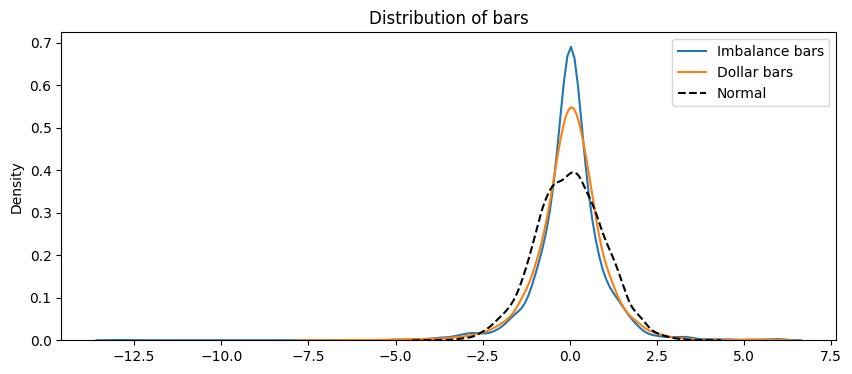

In [60]:
plt.figure(figsize=(10,4))
sns.kdeplot((dollar_imb_returns - dollar_imb_returns.mean()) / dollar_imb_returns.std(), label="Imbalance bars")
sns.kdeplot((dollar_returns - dollar_returns.mean()) / dollar_returns.std(), label="Dollar bars")
sns.kdeplot(np.random.normal(size=len(dollar_returns)), label="Normal", color='black', linestyle="--")
plt.title('Distribution of bars')
plt.legend()
plt.show()

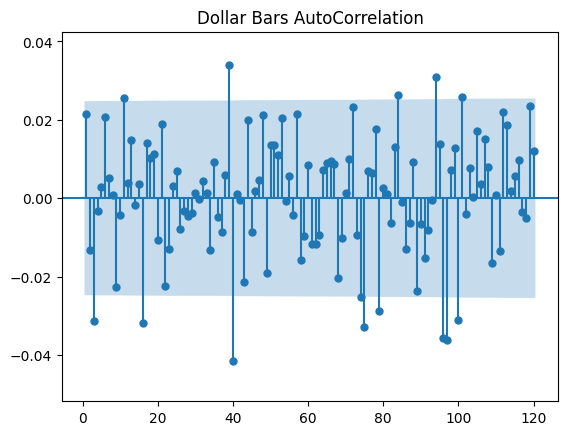

In [61]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dollar_returns,lags=120,alpha=0.05, adjusted=True, fft=True,zero=False, auto_ylims=True)
plt.title('Dollar Bars AutoCorrelation')
plt.show()

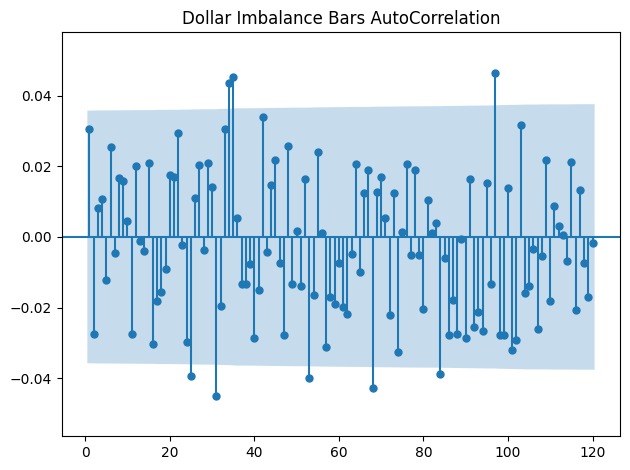

In [62]:
plot_acf(dollar_imb_returns, lags=120,alpha=0.05, adjusted=True, fft=True,zero=False, auto_ylims=True)
plt.title('Dollar Imbalance Bars AutoCorrelation')
plt.tight_layout()
plt.show()

In [63]:
def plot_autocorr(bar_types,bar_returns):
    f,axes=plt.subplots(len(bar_types),figsize=(10,4))
    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, lags=120, ax=axes[i],
                                 alpha=0.05, adjusted=True, fft=True,
                                 zero=False, auto_ylims=True,
                                 title=f'{typ} AutoCorr')
    plt.tight_layout()   
    
def plot_dist(bar_types,bar_rets):
    f,axes=plt.subplots(len(bar_types),figsize=(10,4))
    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        g = sns.histplot(bar, ax=axes[i], kde=False, label=typ)
        g.set(yscale='log')
        axes[i].legend()
    plt.tight_layout()   

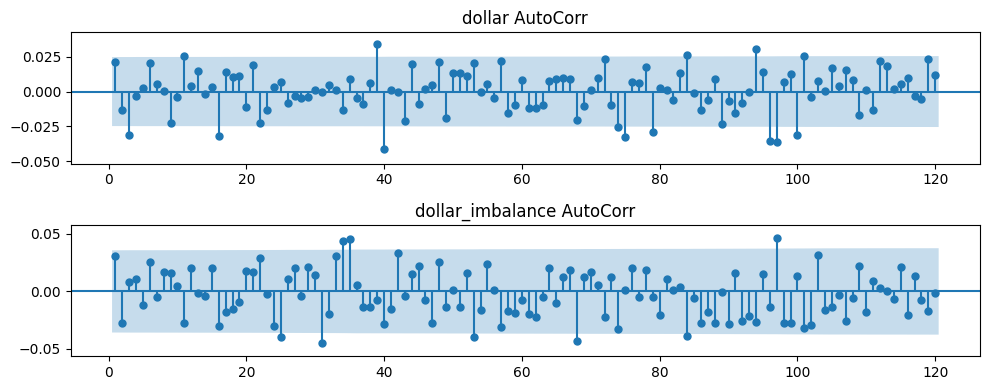

In [64]:
bar_types = ['dollar', 'dollar_imbalance']
bar_returns = [dollar_returns, dollar_imb_returns]
plot_autocorr(bar_types,bar_returns)

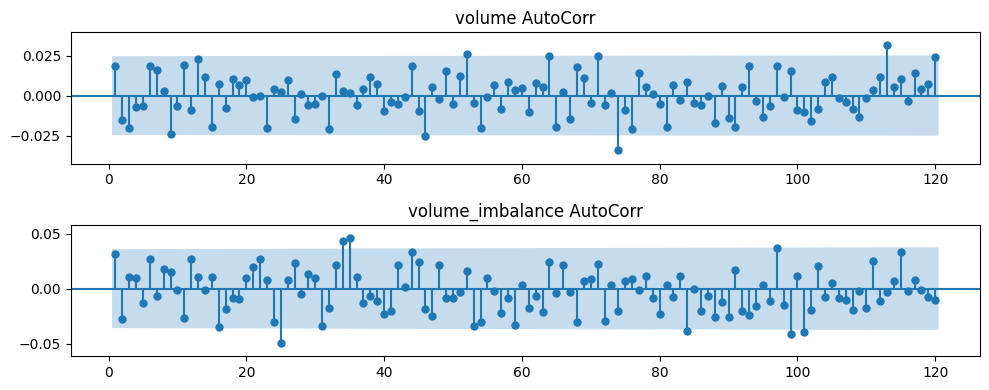

In [65]:
bar_types = ['volume', 'volume_imbalance']
bar_returns = [volume_returns, volume_imb_returns]
plot_autocorr(bar_types,bar_returns)

### Bollinger Bands

In [66]:
def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    """
    Function to calculate Bollinger Bands.
    :param df: DataFrame containing stock price data (must have 'Close' column)
    :param window: The rolling window for calculating the moving average and standard deviation
    :param num_std_dev: Number of standard deviations to use for the bands
    :return: DataFrame with Bollinger Bands (Upper, Middle, Lower)
    """
    # Calculate the rolling mean (middle band) and rolling standard deviation
    df['SMA'] = df['Close'].rolling(window=window).mean()
    df['STD'] = df['Close'].rolling(window=window).std()

    # Calculate the upper and lower Bollinger Bands
    df['Upper Band'] = df['SMA'] + (df['STD'] * num_std_dev)
    df['Lower Band'] = df['SMA'] - (df['STD'] * num_std_dev)

    return df




In [124]:
def plot_bollinger_bands(df):
    """
    Function to plot the Bollinger Bands along with the closing price.
    :param df: DataFrame with 'Close', 'Upper Band', and 'Lower Band'
    """
    plt.figure(figsize=(10,6))
    plt.plot(df['Close'], label='Close Price', color='blue')
    plt.plot(df['Upper Band'], label='Upper Bollinger Band', color='red', linestyle='--')
    plt.plot(df['Lower Band'], label='Lower Bollinger Band', color='green', linestyle='--')
    plt.fill_between(df.index, df['Lower Band'], df['Upper Band'], color='gray', alpha=0.3)
    plt.title('Bollinger Bands')
    plt.legend()
    plt.show()

[*********************100%***********************]  1 of 1 completed


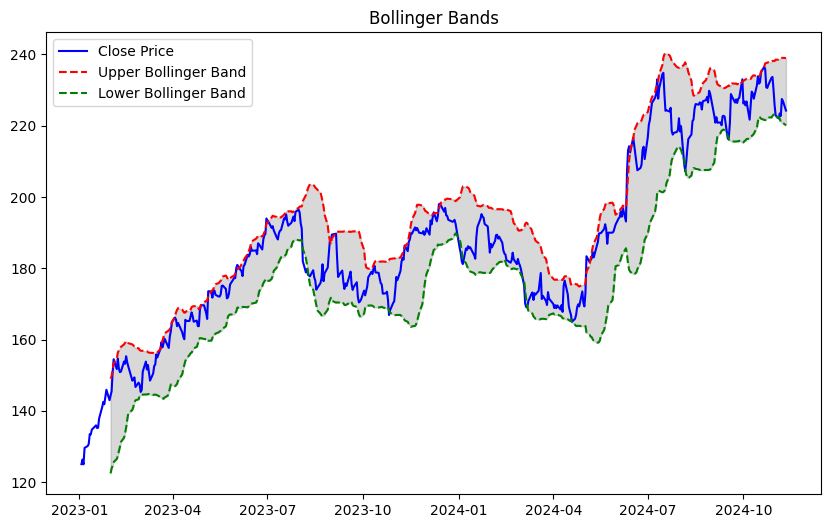

In [166]:
# Example: Fetch stock data for a specific ticker
ticker = 'AAPL'  # Apple stock as an example
start_date = '2023-01-01'

# Fetch historical stock data
df = yf.download(ticker, start=start_date)
df.columns = df.columns.get_level_values(0)

# Calculate Bollinger Bands
df_with_bands = calculate_bollinger_bands(df,20,2)

# Plot the Bollinger Bands
plot_bollinger_bands(df_with_bands)

In [187]:
def num_of_crossing(df):
    up_crossing, down_crossing = 0, 0
    df['Close_shift1'] = df_with_bands['Close'].shift(1)
    ups = ((df['Close_shift1'].values<df['Upper Band'].values)&(df['Open'].values>df['Upper Band'].values))|\
                      ((df['Open'].values<df['Upper Band'].values)&(df['Close'].values>df['Upper Band'].values))
    downs = ((df['Close_shift1'].values>df['Lower Band'].values)&(df['Open'].values<df['Lower Band'].values))|\
                        ((df['Open'].values>df['Lower Band'].values)&(df['Close'].values<df['Lower Band'].values))
    indices = df[ups|downs].index
    up_crossing = sum(ups)
    down_crossing = sum(downs)
    return up_crossing + down_crossing, indices.tolist()


In [188]:
num_of_cross, crossing_index = num_of_crossing(df_with_bands)
print(f"Number of Crossing: {num_of_cross}")

Number of Crossing: 35


In [189]:
df['Return'] = np.log(df['Close']).diff()
series = df['Return']
getTEvents(series, h=0.05)

[Timestamp('2023-01-30 00:00:00+0000', tz='UTC'),
 Timestamp('2023-02-02 00:00:00+0000', tz='UTC'),
 Timestamp('2023-02-06 00:00:00+0000', tz='UTC'),
 Timestamp('2023-03-03 00:00:00+0000', tz='UTC'),
 Timestamp('2023-04-10 00:00:00+0000', tz='UTC'),
 Timestamp('2023-05-05 00:00:00+0000', tz='UTC'),
 Timestamp('2023-05-09 00:00:00+0000', tz='UTC'),
 Timestamp('2023-08-04 00:00:00+0000', tz='UTC'),
 Timestamp('2023-08-08 00:00:00+0000', tz='UTC'),
 Timestamp('2023-09-06 00:00:00+0000', tz='UTC'),
 Timestamp('2023-09-18 00:00:00+0000', tz='UTC'),
 Timestamp('2024-01-02 00:00:00+0000', tz='UTC'),
 Timestamp('2024-01-08 00:00:00+0000', tz='UTC'),
 Timestamp('2024-01-30 00:00:00+0000', tz='UTC'),
 Timestamp('2024-03-21 00:00:00+0000', tz='UTC'),
 Timestamp('2024-03-27 00:00:00+0000', tz='UTC'),
 Timestamp('2024-04-11 00:00:00+0000', tz='UTC'),
 Timestamp('2024-04-15 00:00:00+0000', tz='UTC'),
 Timestamp('2024-05-03 00:00:00+0000', tz='UTC'),
 Timestamp('2024-05-06 00:00:00+0000', tz='UTC'),


In [194]:
df.loc[crossing_index]

Price                       Adj Close       Close        High         Low  \
Date                                                                        
2023-02-03 00:00:00+00:00  152.892181  154.500000  157.380005  147.830002   
2023-03-02 00:00:00+00:00  144.612061  145.910004  146.710007  143.899994   
2023-03-20 00:00:00+00:00  155.999832  157.399994  157.820007  154.149994   
2023-03-21 00:00:00+00:00  157.863129  159.279999  159.399994  156.539993   
2023-03-31 00:00:00+00:00  163.433121  164.899994  165.000000  161.910004   
2023-05-05 00:00:00+00:00  172.026016  173.570007  174.300003  170.759995   
2023-05-08 00:00:00+00:00  171.956635  173.500000  173.850006  172.110001   
2023-06-01 00:00:00+00:00  178.734879  180.089996  180.119995  176.929993   
2023-06-30 00:00:00+00:00  192.510452  193.970001  194.479996  191.259995   
2023-07-27 00:00:00+00:00  191.766068  193.220001  197.199997  192.550003   
2023-08-04 00:00:00+00:00  180.620590  181.990005  187.380005  181.919998   
2023-08-09 00:00:00+00:00  176.849197  178.190002  180.929993  177.009995   
2023-09-01 00:00:00+00:00  188.288300  189.460007  189.919998  188.279999   
2023-10-26 00:00:00+00:00  165.857864  166.889999  171.380005  165.669998   
2023-11-10 00:00:00+00:00  185.491272  186.399994  186.570007  183.529999   
2023-12-08 00:00:00+00:00  194.755890  195.710007  195.990005  193.669998   
2023-12-13 00:00:00+00:00  196.994919  197.960007  198.000000  194.850006   
2024-01-02 00:00:00+00:00  184.734970  185.639999  188.440002  183.889999   
2024-03-04 00:00:00+00:00  174.468704  175.100006  176.899994  173.789993   
2024-03-05 00:00:00+00:00  169.506668  170.119995  172.039993  169.619995   
2024-05-03 00:00:00+00:00  182.718857  183.380005  187.000000  182.660004   
2024-05-07 00:00:00+00:00  181.742386  182.399994  184.899994  181.320007   
2024-06-11 00:00:00+00:00  206.683105  207.149994  207.160004  193.630005   
2024-06-17 00:00:00+00:00  216.181656  216.669998  218.949997  212.720001   
2024-07-10 00:00:00+00:00  232.454880  232.979996  233.080002  229.250000   
2024-08-05 00:00:00+00:00  208.798340  209.270004  213.500000  196.000000   
2024-08-06 00:00:00+00:00  206.762924  207.229996  209.990005  201.070007   
2024-09-16 00:00:00+00:00  216.082275  216.320007  217.220001  213.919998   
2024-09-17 00:00:00+00:00  216.551743  216.789993  216.899994  214.500000   
2024-09-30 00:00:00+00:00  232.743942  233.000000  233.000000  229.649994   
2024-10-15 00:00:00+00:00  233.593002  233.850006  237.490005  232.369995   
2024-10-18 00:00:00+00:00  234.741730  235.000000  236.179993  234.009995   
2024-11-01 00:00:00+00:00  222.665024  222.910004  225.350006  220.270004   
2024-11-04 00:00:00+00:00  221.766006  222.009995  222.789993  219.710007   
2024-11-05 00:00:00+00:00  223.204422  223.449997  223.949997  221.139999   

Price                            Open     Volume         SMA       STD  \
Date                                                                     
2023-02-03 00:00:00+00:00  148.029999  154357300  139.493999  6.925669   
2023-03-02 00:00:00+00:00  144.380005   52238100  150.709500  3.070339   
2023-03-20 00:00:00+00:00  155.070007   73641400  150.638500  3.365960   
2023-03-21 00:00:00+00:00  157.320007   73938300  151.178500  3.835076   
2023-03-31 00:00:00+00:00  162.440002   68749800  156.096999  4.380190   
2023-05-05 00:00:00+00:00  170.979996  113316400  166.029500  3.177601   
2023-05-08 00:00:00+00:00  172.479996   55962800  166.603000  3.441849   
2023-06-01 00:00:00+00:00  177.699997   68901800  173.610501  2.865011   
2023-06-30 00:00:00+00:00  191.630005   85069600  184.493000  4.006849   
2023-07-27 00:00:00+00:00  196.020004   47460200  191.975500  2.007407   
2023-08-04 00:00:00+00:00  185.520004  115799700  192.165001  3.345320   
2023-08-09 00:00:00+00:00  180.869995   60378500  190.684001  5.890164   
2023-09-01 00:00:00+00:00  189.490005   45732600  179.652000  4.379205   
2023-10-26 00:00:00+00:00  170.369995   

In [70]:
yf.download("FEZ", start='2022-11-11', end='2024-10-10', interval="1h") 

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FEZ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2022-11-11 -> 2024-10-10) (Yahoo error = "1h data not available for startTime=1668142800 and endTime=1728532800. The requested range must be within the last 730 days.")')


Empty DataFrame
Columns: [(Adj Close, FEZ), (Close, FEZ), (High, FEZ), (Low, FEZ), (Open, FEZ), (Volume, FEZ)]
Index: []

In [ ]:
def test_t_abs(absTheta,t,E_bs):
    """
    Bool function to test inequality
    *row is assumed to come from df.itertuples()
    -absTheta: float(), row.absTheta
    -t: pd.Timestamp()
    -E_bs: float(), row.E_bs
    """
    return (absTheta >= t*E_bs)

def agg_imbalance_bars(df):
    """
    Implements the accumulation logic
    """
    start = df.index[0]  
    bars = []
    for row in df.itertuples():
        t_abs = row.absTheta # absolute of cumulative theta
        rowIdx = row.Index
        E_bs = row.E_bs      # expected imbalance dollar values
        t = df.loc[start:rowIdx].shape[0]
        print(t_abs, t, E_bs)
        if t<1: t=1 # if t lt 1 set equal to 1
        if test_t_abs(t_abs,t,E_bs):
            bars.append((start,rowIdx,t,t_abs,E_bs))
            start = rowIdx
    return bars

In [ ]:
bars = agg_imbalance_bars(df0)
test_imb_bars = (pd.DataFrame(bars,columns=['start','stop','Ts', 'abs_theta', 'E_bs']).drop_duplicates())
test_imb_bars

68326993.5 1 68326993.5
144987829.5 2 72675085.23913044
281649911.5 3 95884474.49244332
154448759.5 4 32637228.786300246
31555027.0 2 -4102954.3197559877
106121733.5 2 12016247.178487644
198192500.25 2 26641320.501818277
416136024.0 2 58431573.38746873
637101407.75 2 -112170094.18287073
563478447.25 2 76087625.69815011
328002932.75 2 -54805436.29593274
198021442.25 2 19889251.52897755
764743019.75 2 87166452.62227598
1368682080.25 2 148317830.66764215
327158831.25 2 12281342.935785001
121140586.75 2 -11926796.515170006
44930877.25 2 -18864193.159054987
525701.75 2 -21554426.651400313
53927086.75 2 -13829254.25532669
85034983.0 2 -9287503.097802354
104779415.0 2 -6404409.037859319
87062045.5 2 -7510208.450838044
57860206.25 2 -9600358.77125527
91756863.5 2 -5462982.729309186
128372494.5 2 -1507143.8394270164
224807339.5 2 7603174.68006117
137897559.0 2 -1103863.3465516344
195895595.25 2 4293465.83532115
254232335.25 2 9189712.447128631
321317054.25 2 14397087.610719541
207680180.25 2 29

start                      stop  Ts     abs_theta  \
0     2022-11-11 06:00:00+00:00 2022-11-11 06:00:00+00:00   1  6.832699e+07   
1     2022-11-11 06:00:00+00:00 2022-11-11 09:00:00+00:00   4  1.544488e+08   
2     2022-11-11 09:00:00+00:00 2022-11-11 10:00:00+00:00   2  3.155503e+07   
3     2022-11-11 10:00:00+00:00 2022-11-11 11:00:00+00:00   2  1.061217e+08   
4     2022-11-11 11:00:00+00:00 2022-11-11 12:00:00+00:00   2  1.981925e+08   
...                         ...                       ...  ..           ...   
11392 2024-11-08 16:00:00+00:00 2024-11-08 17:00:00+00:00   2  1.070975e+11   
11393 2024-11-08 17:00:00+00:00 2024-11-08 18:00:00+00:00   2  1.075623e+11   
11394 2024-11-08 18:00:00+00:00 2024-11-08 19:00:00+00:00   2  1.070622e+11   
11395 2024-11-08 19:00:00+00:00 2024-11-08 20:00:00+00:00   2  1.056837e+11   
11396 2024-11-08 20:00:00+00:00 2024-11-08 21:00:00+00:00   2  1.053778e+11   

               E_bs  
0      6.832699e+07  
1      3.263723e+07  
2     -4.102954e+06  
3      1.201625e+07  
4      2.664132e+07  
...             ...  
11392  2.309992e+08  
11393  2.504850e+08  
11394  1.879318e+08  
11395  5.740097e+07  
11396  2.712610e+07  

[11397 rows x 5 columns]

In [ ]:
df0.shape

(11414, 5)

In [ ]:
len(bars)

11397

In [ ]:
test_imb_bars.Ts.describe().round()

count    11397.0
mean         2.0
std          0.0
min          1.0
25%          2.0
50%          2.0
75%          2.0
max         17.0
Name: Ts, dtype: float64

<Axes: xlabel='stop'>

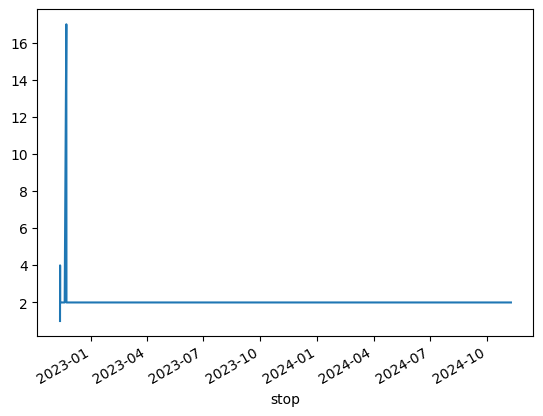

In [ ]:
test_imb_bars.set_index('stop')['Ts'].plot()

In [ ]:
dvImbBars = df.price.loc[test_imb_bars.stop].drop_duplicates()
dvImbBars

Datetime
2022-11-11 06:00:00+00:00    3988.50
2022-11-11 09:00:00+00:00    3984.00
2022-11-11 10:00:00+00:00    3976.50
2022-11-11 11:00:00+00:00    3980.50
2022-11-11 12:00:00+00:00    3980.75
                              ...   
2024-11-08 17:00:00+00:00    6024.75
2024-11-08 18:00:00+00:00    6034.00
2024-11-08 19:00:00+00:00    6033.00
2024-11-08 20:00:00+00:00    6027.25
2024-11-08 21:00:00+00:00    6023.50
Name: price, Length: 5535, dtype: float64

In [ ]:
dvBar = dv_bar_df.price
dvBar

NameError: name 'dv_bar_df' is not defined

In [ ]:
ib_data['b'] = 1
ib_data['Close_diff'] = ib_data['Close'].diff()
ib_data['b'] = np.where(ib_data['Close_diff'] != 0, abs(ib_data['Close_diff'])/ib_data['Close_diff'], np.nan)
ib_data['b'] = ib_data['b'].ffill()

In [ ]:
wdow = len(ib_data)//1000000
E_imbalance_init = 100
E_T_init = 3
E_imbalance = E_imbalance_init
E_T = E_T_init
cum_theta = 0
imbalance_array = pd.DataFrame(columns=['Imbalance'])
T_array = pd.DataFrame(columns=['T'])
i_prev = 0

for i in range(1, len(ib_data)):
    imbalance = ib_data.iloc[i]['b'] * ib_data.iloc[i]['Volume'] * ib_data.iloc[i]['Close']
    cum_theta += imbalance
    imbalance_array.loc[len(imbalance_array)] = [imbalance]
    if abs(cum_theta) >= E_T * abs(E_imbalance):
        print(cum_theta, E_imbalance, E_T)
        cum_theta = 0
        T_array.loc[len(T_array)] = [i - i_prev]
        i_prev = i
        E_T = T_array['T'].ewm(wdow).mean().values[-1]
        E_imbalance = imbalance_array['Imbalance'].ewm(wdow).mean().values[-1]

68326993.5 100 3
76660836.0 68326993.5 1.0
136662082.0 76660836.0 1.0
-250094884.5 136662082.0 1.0
384580997.0 -122893732.5 2.0
-1053237431.75 217943523.75 3.0
1200579855.0 -1053237431.75 1.0
1298407650.5 1200579855.0 1.0
19597793748.75 837392000.0 23.0


In [ ]:
T_array

T
0     1
1     1
2     1
3     2
4     3
5     1
6     1
7    23
8  1027

<Axes: xlabel='Datetime'>

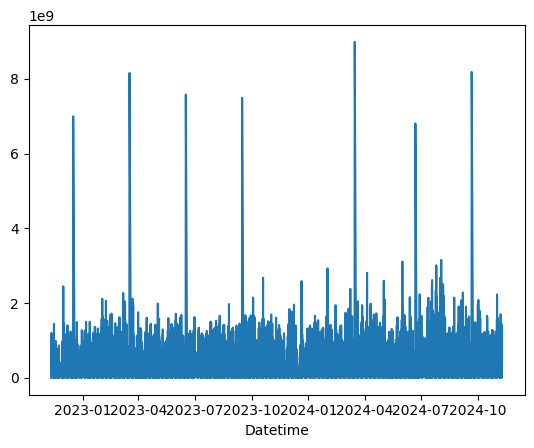

In [ ]:
sns.lineplot(ib_data['Volume']*ib_data['Close'])

In [ ]:
imbalance_array

Imbalance
0      6.832699e+07
1      7.666084e+07
2      1.366621e+08
3     -1.272012e+08
4     -1.228937e+08
...             ...
11409  5.372812e+08
11410  4.648292e+08
11411 -5.001538e+08
11412 -1.378438e+09
11413 -3.058974e+08

[11414 rows x 1 columns]